In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# sys.path.append("..")
# from functions import build_vocab, encode_sequences
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
import re
from collections import Counter

def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'[.,:]', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@\w+', '[name]', text)
    return text

def tokenize_text(text):
    return clean_text(text).split()

nameslist = pd.read_csv('../../data/names.csv')
nameslist = nameslist['name'].tolist()

def build_vocab(texts):
    tokenized_texts = [tokenize_text(text) for text in texts]
    all_words = [word for text in tokenized_texts for word in text if word.isalnum()]
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
    
    top_words = sorted_words[:1000]
    
    word_to_idx = {word: idx+1 for idx, word in enumerate(top_words)}
    word_to_idx['<PAD>'] = 0
    word_to_idx['<UNK>'] = len(word_to_idx)
    word_to_idx['[name]'] = len(word_to_idx)
    return word_to_idx, tokenized_texts

def is_illegal_word(word):
    return any(char.isalnum() == False for char in word) or word not in word_to_idx

def encode_sequences(tokenized_texts, word_to_idx, seq_length=6):
    sequences = []
    for tokens in tokenized_texts:
        if len(tokens) < seq_length:
            continue
        for i in range(seq_length, len(tokens)):
            seq = tokens[i-seq_length:i] 
            target = tokens[i]  
            if any(is_illegal_word(word) for word in seq) or is_illegal_word(target):
                continue
            encoded_seq = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in seq]
            encoded_target = word_to_idx.get(target, word_to_idx['<UNK>'])
            sequences.append((encoded_seq, encoded_target))
    return sequences

folder_path = '../../data/x'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = sorted(csv_files)[:20]

dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

texts = df['text'].tolist()

print(f"Loaded {len(texts)} text samples from CSV.")

word_to_idx, tokenized_texts = build_vocab(texts)
sequences = encode_sequences(tokenized_texts, word_to_idx, seq_length=4)

print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Number of sequences: {len(sequences)}")

Loaded 198575 text samples from CSV.
Vocabulary size: 1003
Number of sequences: 445806


In [3]:
class TextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, target = self.sequences[idx]
        return torch.tensor(sequence), torch.tensor(target)

class NextWordLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, repetition_penalty=1.0):
        super(NextWordLSTM, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.repetition_penalty = repetition_penalty
        
        self.embedding = None
        self.lstm = None
        self.fc = None
    
    def initialize_vocab(self, vocab_size):
        self.embedding = nn.Embedding(vocab_size, self.embed_size)
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, vocab_size)
    
    def forward(self, x):
        if self.embedding is None or self.lstm is None or self.fc is None:
            raise RuntimeError("Model not initialized. Call initialize_vocab() first.")
        
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last LSTM cell
        out = self.fc(lstm_out)
        
        if self.repetition_penalty != 1.0:
            for i in range(out.size(0)):
                for token in x[i]:
                    out[i, token] /= self.repetition_penalty
        
        return out


train_sequences, val_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

train_dataset = TextDataset(train_sequences)
val_dataset = TextDataset(val_sequences)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [4]:
def validate_model(model, val_loader, criterion):
    model.eval()  
    total_loss = 0
    total_correct = 0
    with torch.no_grad():  
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_correct / len(val_loader.dataset)
    return avg_loss, avg_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()  

        for batch_idx, (sequences, targets) in enumerate(train_loader):
            sequences, targets = sequences.to(device), targets.to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss, val_acc = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Train Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  
            best_model = model.state_dict()  # Save the model state
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    model = best_model
    return train_losses, val_losses, val_accuracies


model = NextWordLSTM(embed_size=128, hidden_size=256, num_layers=2).to(device)
model.initialize_vocab(len(word_to_idx))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Ensure all model parameters are on the correct device
model = model.to(device)
for param in model.parameters():
    param.data = param.data.to(device)

print("Starting training...")
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Starting training...


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

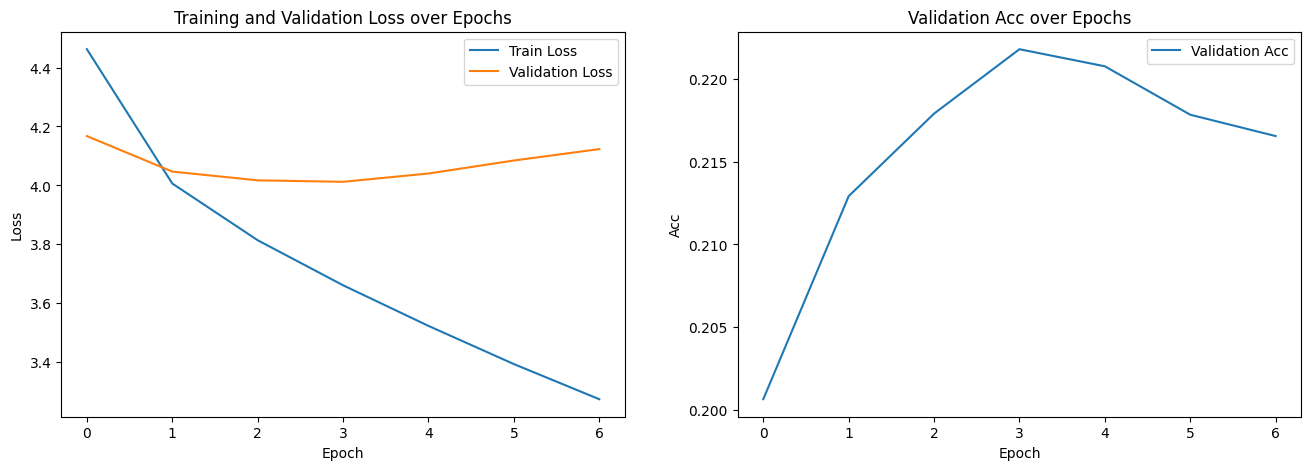

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].legend()

axs[1].plot(val_accuracies, label="Validation Acc")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Acc")
axs[1].set_title("Validation Acc over Epochs")
axs[1].legend()

plt.show()

In [ ]:
import json

# Save the vocabulary (word_to_idx dictionary)
vocab_save_path = 'vocabulary.json'
with open(vocab_save_path, 'w') as f:
    json.dump(word_to_idx, f)
print(f"Vocabulary saved to {vocab_save_path}")

#save model
model_save_path = 'model_low_vocab.pth'
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")

Vocabulary saved to vocabulary.json
Model saved to model_low_vocab.pth


In [ ]:
def predict_next_word(model, sequence, idx_to_word):
    model.eval()
    sequence = torch.tensor(sequence).unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(sequence)
        predicted_idx = torch.argmax(output, dim=1).item()
    return idx_to_word[predicted_idx]


idx_to_word = {idx: word for word, idx in word_to_idx.items()}

indata = [word_to_idx[words] for words in "what did".split()]
print(predict_next_word(model, indata, idx_to_word))

you


In [ ]:
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

for i in range(100):
    sequence, target = val_dataset[i+1000]
    sequence_words = [idx_to_word[idx.item()] for idx in sequence]
    target_word = idx_to_word[target.item()]
    print(f"Sequence {i + 1}: {' '.join(sequence_words)} -> {target_word}")

Sequence 1: time to play wow -> again
Sequence 2: yesterday another 2 weeks -> of
Sequence 3: at store so had -> to
Sequence 4: my story and for -> their
Sequence 5: its been a week -> since
Sequence 6: sleep who knew saying -> say
Sequence 7: be living in a -> home
Sequence 8: me a dm we -> can
Sequence 9: lost my first game -> of
Sequence 10: guy fml but almost -> a
Sequence 11: i had someone to -> come
Sequence 12: summer u came to -> to
Sequence 13: day week seems too -> long
Sequence 14: has failed me there -> was
Sequence 15: gonna be not good -> xx
Sequence 16: are your plans for -> the
Sequence 17: just found out the -> second
Sequence 18: myself i bit off -> all
Sequence 19: more weeks left then -> hello
Sequence 20: these at the end -> of
Sequence 21: end to a bad -> week
Sequence 22: it was all worth -> it
Sequence 23: my hair is short -> and
Sequence 24: are on that side -> of
Sequence 25: about this i did -> this
Sequence 26: days ago and no -> one
Sequence 27: and was on 